In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
def load_image(image_path):
    image=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    image=cv2.resize(image,(256,256))
    """
    rows, cols = image.shape
    hann_row = np.hanning(rows)
    hann_col = np.hanning(cols)t
    hann_2d = np.outer(hann_row, hann_col)
    # Apply the Hann window to the image
    image=image*hann_2d
    """
    return image
def preprocess_image(image):
    image=image.astype(np.float32)/255.0
    return image


In [ ]:
from google.colab import files
upload=files.upload()

Saving 227.jpg to 227.jpg
Saving 228.jpg to 228.jpg


In [ ]:
image_path1='325.jpg'
image_path2='326.jpg'

In [ ]:
from google.colab import files
upload=files.upload()

Saving 325.jpg to 325.jpg
Saving 326.jpg to 326.jpg


In [ ]:
import tensorflow as tf

In [ ]:
plt.imshow(image1)


In [ ]:
image1=preprocess_image(load_image(image_path1))
image2=preprocess_image(load_image(image_path2))

In [ ]:
plt.imshow(image2)

In [ ]:
from numpy.fft import fft2,ifft2,fftshift
from scipy.signal import correlate2d
def zero_pad_image(image, pad_factor=2):
    padded_image = np.pad(image,
                          ((image.shape[0]*(pad_factor-1)//2,image.shape[0]*(pad_factor-1)//2),
                           (image.shape[1]*(pad_factor-1)//2,image.shape[1]*(pad_factor-1)//2)),
                            mode='constant',constant_values=0)
    return padded_image
def register_images(image1, image2):
    padded_image1=zero_pad_image(image1)
    padded_image2=zero_pad_image(image2)
    F1=fft2(padded_image1)
    F2=fft2(padded_image2)
    cross_power_spectrum=(F1*np.conj(F2))/np.abs(F1*np.conj(F2))
    phase_corr=np.abs(ifft2(cross_power_spectrum))
    peak=np.unravel_index(np.argmax(phase_corr),phase_corr.shape)
    shift_x=peak[1]-phase_corr.shape[1]//2
    shift_y=peak[0]-phase_corr.shape[0]//2
    return shift_x,shift_y
def visualize_registration(image1, image2, shift):
    if shift is None:
        print("No valid shift to visualize.")
        return
    translated_image2=np.roll(image2, int(shift[1]), axis=0)
    translated_image2=np.roll(translated_image2,int(shift[0]), axis=1)
    fig,axes=plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title("Input Image 1")
    axes[0].axis('off')
    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title("Input Image 2")
    axes[1].axis('off')
    axes[2].imshow(translated_image2, cmap='gray')
    axes[2].set_title("Registered Image 2")
    axes[2].axis('off')
    plt.tight_layout()
    plt.show()
shift=register_images(image1,image2)
print(f"Estimated sub-pixel shift:{shift}")
visualize_registration(image1,image2,shift)


Estimated sub-pixel shift:(-140, -249)


Estimated sub-pixel shift:(-139.84408320214862, -249.10060667048197)


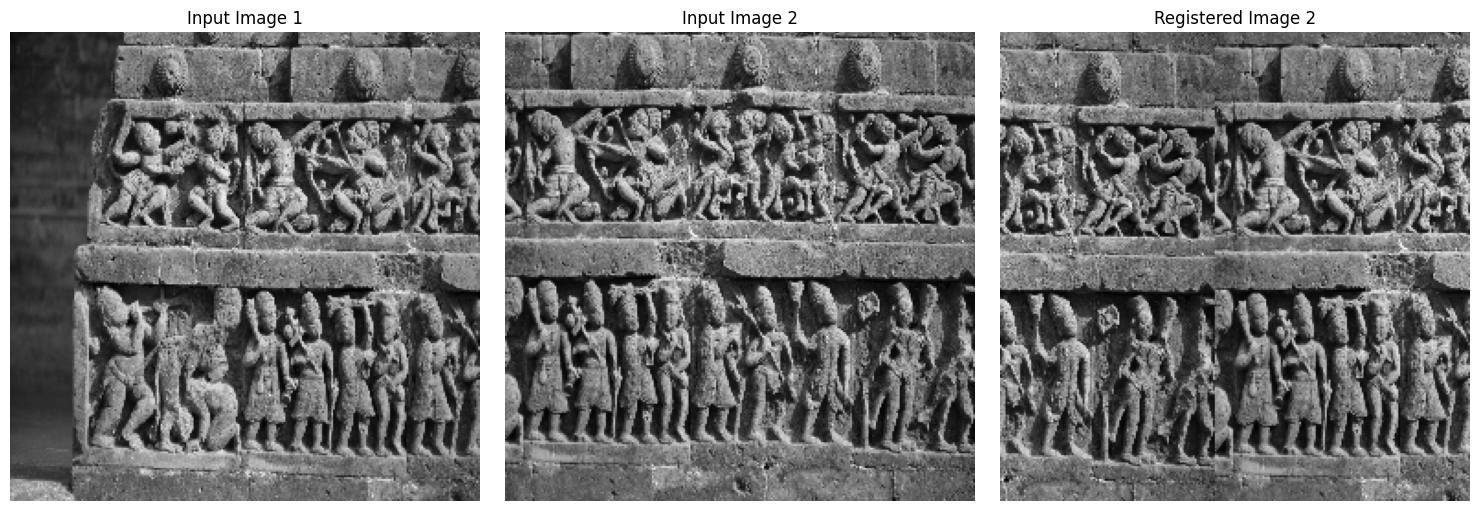

In [ ]:
def quadratic_interpolation(cross_correlation, peak):
    # Perform quadratic interpolation around the given peak.
    peak_y, peak_x = peak
    if not(1 <= peak_x < cross_correlation.shape[1] - 1 and 1 <= peak_y < cross_correlation.shape[0] - 1):
        print("Error: Peak location is too close to the edge for interpolation.")
        return None, None
    dy = (cross_correlation[peak_y + 1, peak_x] - cross_correlation[peak_y - 1, peak_x]) / 2.0
    dx = (cross_correlation[peak_y, peak_x + 1] - cross_correlation[peak_y, peak_x - 1]) / 2.0
    dxx = (cross_correlation[peak_y, peak_x + 1] + cross_correlation[peak_y, peak_x - 1] - 2 * cross_correlation[peak_y, peak_x])
    dyy = (cross_correlation[peak_y + 1, peak_x] + cross_correlation[peak_y - 1, peak_x] - 2 * cross_correlation[peak_y, peak_x])
    sub_pixel_x = peak_x - dx / dxx
    sub_pixel_y = peak_y -dy / dyy
    return sub_pixel_x, sub_pixel_y
def register_images_2(image1, image2):
    padded_image1=zero_pad_image(image1)
    padded_image2=zero_pad_image(image2)
    F1 = fft2(padded_image1)
    F2=fft2(padded_image2)
    cross_power_spectrum=(F1 * np.conj(F2)) / np.abs(F1 * np.conj(F2))
    phase_corr=np.abs(ifft2(cross_power_spectrum))
    peak=np.unravel_index(np.argmax(phase_corr), phase_corr.shape)
    refined_shift=quadratic_interpolation(phase_corr, peak)

    if refined_shift[0] is not None and refined_shift[1] is not None:
        shift_x = refined_shift[0] - phase_corr.shape[1] // 2
        shift_y = refined_shift[1] - phase_corr.shape[0] // 2
    else:
        shift_x = peak[1] - phase_corr.shape[1] // 2
        shift_y = peak[0] - phase_corr.shape[0] // 2

    return shift_x, shift_y
shift=register_images_2(image1,image2)
print(f"Estimated sub-pixel shift:{shift}")
visualize_registration(image1,image2,shift)

In [ ]:
from scipy.optimize import curve_fit

def gaussian_2d(xy,x0,y0,A,sigma_x,sigma_y,offset):
    x, y = xy
    return A * np.exp(-(((x-x0)**2/(2*sigma_x**2))+((y-y0)**2/(2*sigma_y**2))))+offset

def gaussian_interpolation(cross_correlation, peak):
    peak_y, peak_x = peak
    if not(1 <= peak_x < cross_correlation.shape[1] - 1 and 1 <= peak_y < cross_correlation.shape[0] - 1):
        print("Error: Peak location is too close to the edge for interpolation.")
        return None, None
    x=np.arange(peak_x - 1, peak_x + 2)
    y=np.arange(peak_y - 1, peak_y + 2)
    x,y=np.meshgrid(x, y)
    values=cross_correlation[y, x].flatten()

    initial_guess = (peak_x, peak_y, cross_correlation[peak_y, peak_x], 1.0, 1.0, cross_correlation.min())
    try:
        popt, _ = curve_fit(gaussian_2d, (x.flatten(), y.flatten()), values, p0=initial_guess)
        x0, y0, A, sigma_x, sigma_y, offset = popt
        return x0, y0
    except RuntimeError:
        print("Gaussian fit did not converge.")
        return None, None


In [ ]:
def sinc_2d(xy, x0, y0, A, offset):
    x, y = xy
    r_x = (x - x0)
    r_y = (y - y0)
    return A * (np.sinc(r_x) * np.sinc(r_y)) + offset

def sinc_interpolation(cross_correlation, peak):
    peak_y, peak_x = peak
    if not(1 <= peak_x < cross_correlation.shape[1] - 1 and 1 <= peak_y < cross_correlation.shape[0] - 1):
        print("Error: Peak location is too close to the edge for interpolation.")
        return None, None

    x = np.arange(peak_x - 1, peak_x + 2)
    y = np.arange(peak_y - 1, peak_y + 2)
    x, y = np.meshgrid(x, y)
    values = cross_correlation[y, x].flatten()
    initial_guess = (peak_x, peak_y, cross_correlation[peak_y, peak_x], cross_correlation.min())
    try:
        popt, _ = curve_fit(sinc_2d, (x.flatten(), y.flatten()), values, p0=initial_guess)
        x0, y0, A, offset = popt
        return x0, y0
    except RuntimeError:
        print("Sinc fit did not converge.")
        return None, None


Estimated sub-pixel shift:(-139.84890652634147, -249.14621817514308)


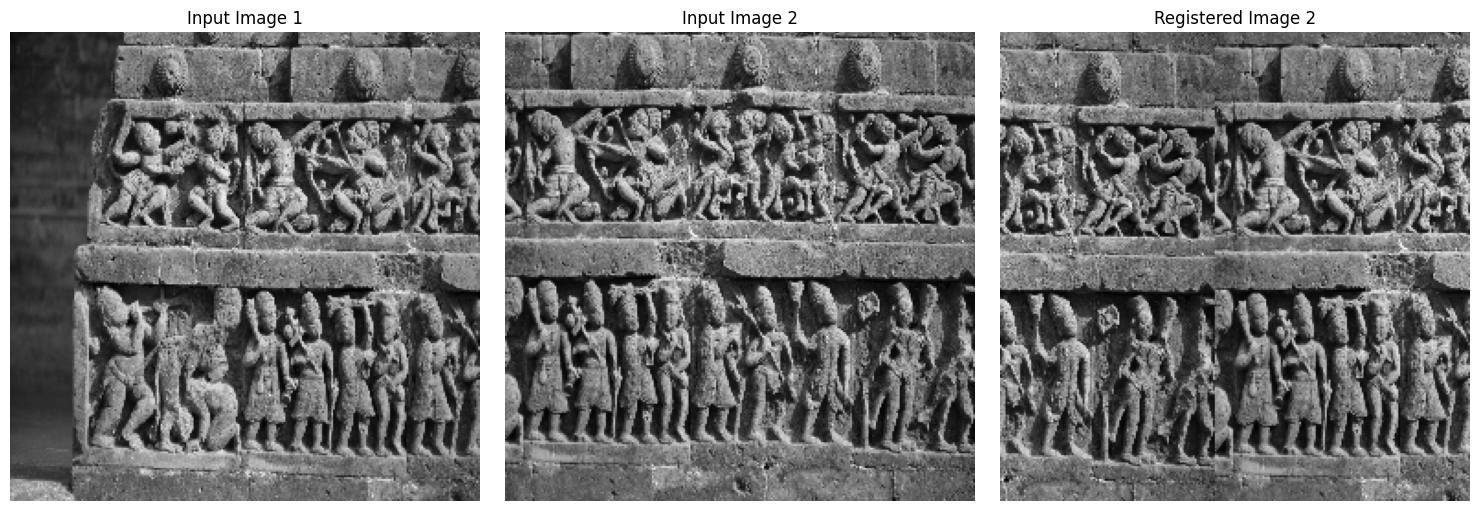

In [ ]:
def register_images_3(image1, image2):
    padded_image1=zero_pad_image(image1)
    padded_image2=zero_pad_image(image2)
    F1 = fft2(padded_image1)
    F2 = fft2(padded_image2)
    cross_power_spectrum=(F1*np.conj(F2)) / np.abs(F1 * np.conj(F2))
    phase_corr = np.abs(ifft2(cross_power_spectrum))
    peak = np.unravel_index(np.argmax(phase_corr), phase_corr.shape)

    # Perform gaussian interpolation to refine the shift
    refined_shift=gaussian_interpolation(phase_corr, peak)

    if refined_shift[0] is not None and refined_shift[1] is not None:
        shift_x=refined_shift[0] - phase_corr.shape[1] // 2
        shift_y=refined_shift[1] - phase_corr.shape[0] // 2
    else:
        shift_x = peak[1]-phase_corr.shape[1] // 2
        shift_y = peak[0]-phase_corr.shape[0] // 2

    return shift_x, shift_y
shift=register_images_3(image1,image2)
print(f"Estimated sub-pixel shift:{shift}")
visualize_registration(image1,image2,shift)

Estimated sub-pixel shift:(-139.72465285839786, -249.12911857747775)


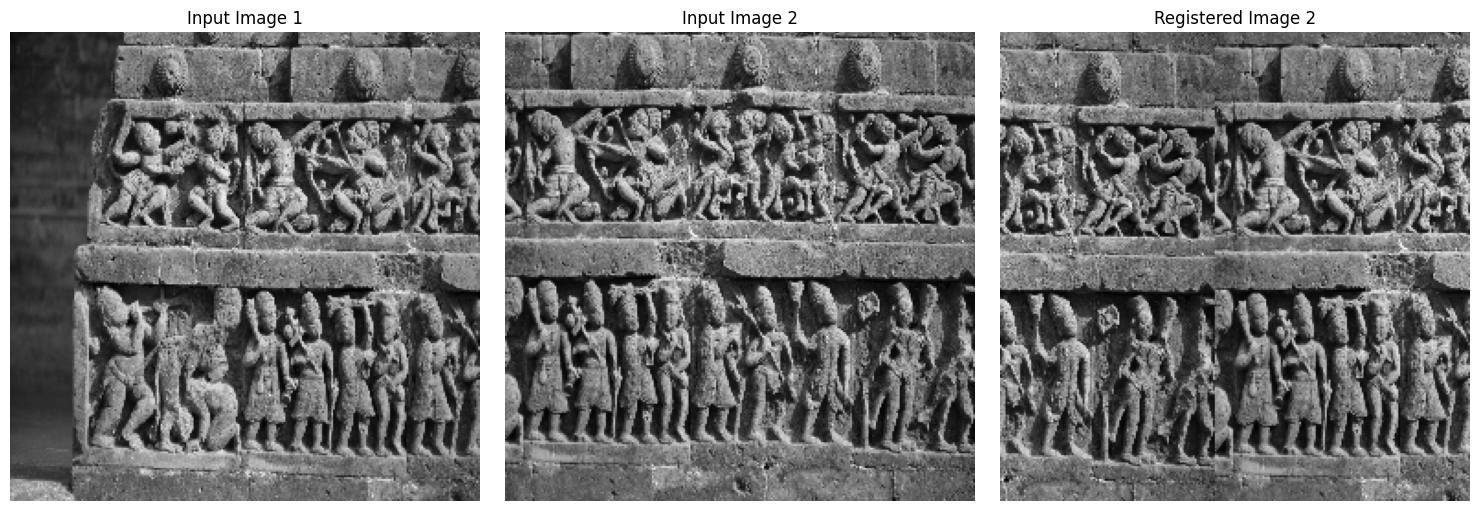

In [ ]:
def register_images_4(image1, image2):
    padded_image1=zero_pad_image(image1)
    padded_image2=zero_pad_image(image2)
    F1 = fft2(padded_image1)
    F2 = fft2(padded_image2)
    cross_power_spectrum = (F1 * np.conj(F2)) / np.abs(F1 * np.conj(F2))
    phase_corr = np.abs(ifft2(cross_power_spectrum))
    peak = np.unravel_index(np.argmax(phase_corr), phase_corr.shape)
    #performing sinc interpolation around te integer peak
    refined_shift =sinc_interpolation(phase_corr, peak)

    if refined_shift[0] is not None and refined_shift[1] is not None:
        shift_x = refined_shift[0] - phase_corr.shape[1] // 2
        shift_y = refined_shift[1] - phase_corr.shape[0] // 2
    else:
        shift_x = peak[1] - phase_corr.shape[1] // 2
        shift_y = peak[0] - phase_corr.shape[0] // 2

    return shift_x, shift_y
shift=register_images_4(image1,image2)
print(f"Estimated sub-pixel shift:{shift}")
visualize_registration(image1,image2,shift)

In [ ]:
plt.imshow(padded_image1)

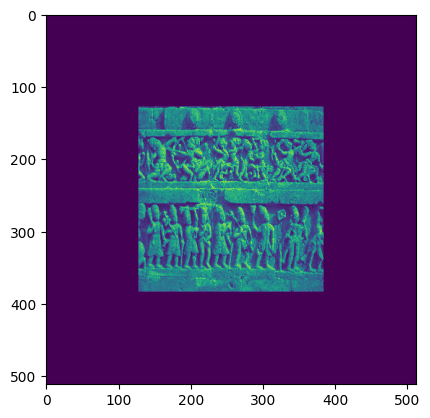

In [ ]:
plt.imshow(padded_image2)

In [ ]:
F1=fft2(image1)
F2=fft2(image2)
cross_power_spectrum=(F1*np.conj(F2))/np.abs(F1*np.conj(F2))
phase_corr=np.abs(ifft2(cross_power_spectrum))
peak=np.unravel_index(np.argmax(phase_corr), phase_corr.shape)
plt.figure(figsize=(8,8))
plt.imshow(fftshift(phase_corr),cmap='gray')
plt.scatter([peak[1]], [peak[0]],color='red', marker='x', s=100, label=f'Peak at {peak}')
plt.title('Phase Correlation')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()
print(f"Estimated translation:{np.array(peak)-np.array(image1.shape)//2}")

Estimated translation:[-121  -12]


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
x=np.arange(0,phase_corr.shape[1])
y=np.arange(0,phase_corr.shape[0])
x,y=np.meshgrid(x,y)
fig=plt.figure(figsize=(12, 8))
ax=fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, fftshift(phase_corr), cmap='viridis')
ax.scatter(peak[1], peak[0], np.max(phase_corr), color='r', s=100, label=f'Peak at {peak}')
ax.set_title('3D View of Phase Correlation (No transformation into log polar coordinates involved here, since images have only translational difference)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Correlation')
plt.legend()
plt.show()
print(f"Estimated translation: {np.array(peak) - np.array(image1.shape) // 2}")

Estimated translation: [-121  -12]


In [ ]:
def fourier_mellin_transform(image):
    rows,cols=image.shape
    center_x,center_y=cols// 2, rows // 2
    f_transform=fft2(image)
    f_transform=fftshift(f_transform)
    r,theta=np.indices((rows, cols),dtype=np.float64)
    r=np.sqrt((r-center_y)**2+(theta-center_x)**2)
    theta = np.arctan2(r-center_y,theta-center_x)
    magnitude=np.abs(f_transform) + 1e-6
    log_magnitude=np.log(magnitude)
    #applying log polar coordinates
    max_radius=np.log(np.max(r) + 1)
    log_polar_transform=np.zeros_like(log_magnitude)
    for i in range(rows):
        for j in range(cols):
            r_log = np.log(r[i, j] + 1)
            theta_val = theta[i, j]
            x = int(r_log*np.cos(theta_val) +center_x)
            y = int(r_log*np.sin(theta_val) +center_y)
            if 0 <= x < rows and 0 <= y < cols:
                log_polar_transform[i, j] = log_magnitude[x, y]
    return log_polar_transform


In [ ]:
from google.colab import files
upload=files.upload()

Saving 2.jpg to 2.jpg
Saving 3.jpg to 3.jpg


In [ ]:
image_path3='2.jpg'
image_path4='3.jpg'

In [ ]:
image3=preprocess_image(load_image(image_path3))
image4=preprocess_image(load_image(image_path4))

In [ ]:
padded_image3=zero_pad_image(image3)
padded_image4=zero_pad_image(image4)

In [ ]:
def register_images_fmt(image1,image2):
    padded_image1=zero_pad_image(image1)
    padded_image2=zero_pad_image(image2)
    F1=fourier_mellin_transform(padded_image1)
    F2=fourier_mellin_transform(padded_image2)
    # F1=fft2(padded_image1)
    # F2=fft2(padded_image2)
    cross_power_spectrum=(F1*np.conj(F2))/np.abs(F1*np.conj(F2))
    phase_corr=np.abs(ifft2(cross_power_spectrum))
    peak=np.unravel_index(np.argmax(phase_corr), phase_corr.shape)
    shift_x=peak[1]-phase_corr.shape[1]//2
    shift_y=peak[0]-phase_corr.shape[0]//2
    return shift_x,shift_y

In [ ]:
def visualize_registration_2(image1, image2, shift):
    if shift is None:
        print("No valid shift to visualize.")
        return
    translated_image2=np.roll(image2, int(shift[1]), axis=0)
    translated_image2=np.roll(translated_image2, int(shift[0]), axis=1)
    fig,axes=plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title("Input Image 1")
    axes[0].axis('off')
    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title("Input Image 2")
    axes[1].axis('off')
    axes[2].imshow(translated_image2, cmap='gray')
    axes[2].set_title("Registered Image 2")
    axes[2].axis('off')
    plt.tight_layout()
    plt.show()
shift=register_images_fmt(image1,image2)#here adding log polar method
print(f"Estimated sub-pixel shift:{shift}")
visualize_registration_2(image3,image4,shift)

Estimated sub-pixel shift:(-256, -256)


Since the images have rotation and scaling difference, The log polar transform was applied and then pahse correlation was performed.
Images chosen earlier(325.jpg and 326.jpg) had only translation difference ordinary phase correlation works fine.

image 3 and image 4 have rotation and scaling difference as well

In [ ]:
cross_power_spectrum2=(f3*np.conj(f4))/np.abs(f3*np.conj(f4))
phase_corr2=np.abs(ifft2(cross_power_spectrum))
peak2=np.unravel_index(np.argmax(phase_corr2), phase_corr2.shape)

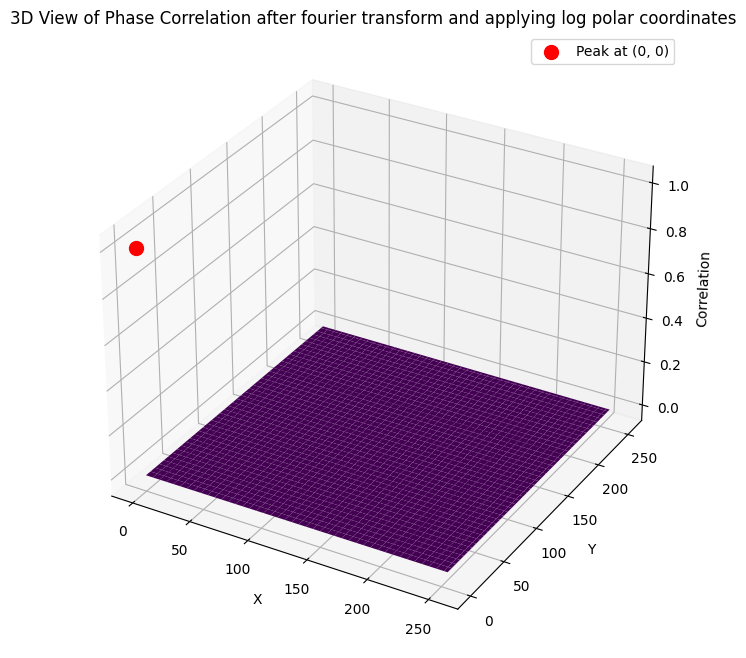

Estimated translation: [-128 -128]


In [ ]:
x=np.arange(0,phase_corr2.shape[1])
y=np.arange(0,phase_corr2.shape[0])
x,y=np.meshgrid(x,y)
fig=plt.figure(figsize=(12, 8))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(x,y,fftshift(phase_corr2),cmap='viridis')
ax.scatter(peak2[1],peak2[0],np.max(phase_corr2),color='r',s=100, label=f'Peak at {peak2}')
ax.set_title('3D View of Phase Correlation after fourier transform and applying log polar coordinates')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Correlation')
plt.legend()
plt.show()
print(f"Estimated translation: {np.array(peak2)-np.array(image3.shape)//2}")